In [1]:
from datetime import datetime, time
import pandas as pd
import numpy as np


In [2]:
files_FEDXC01 = ["FED001_091022_00.CSV", "FED001_091922_00_MERGED.CSV", "FED001_092622_00.CSV", "FED001_100322_00.CSV"]
files_FEDXC07 = ["FED007_091022_00.CSV", "FED007_091922_00.CSV", "FED007_092622_00.CSV", "FED007_100322_00.CSV"]


In [3]:
def make_merged_df(csvfiles):
    df_array =[]
    for f in csvfiles:
        filename = "../data/" + f
        df_array.append(pd.read_csv(filename))
    
    merged_df = pd.concat(df_array)

    return merged_df

In [4]:
df_01 = make_merged_df(files_FEDXC01)
df_07 = make_merged_df(files_FEDXC07)

In [5]:
def convert_to_datetime(timestamp):
    try:
        dt = datetime.strptime(timestamp, '%m/%d/%Y %H:%M:%S')
    except:
        dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')

    return dt
    
def get_FEDevents_from_df(df, eventname="Pellet"):

    df_events = df[df["Event"] == eventname].iloc[:,0]

    df_ts = df_events.apply(lambda x: convert_to_datetime(x))
    timestamps = list(df_ts)

    t0 = timestamps[0]
    refpoint = datetime.combine(t0.date(), time(7,0))
    
    pellettimes = []
    for t in timestamps:
        Deltat = t-refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds/3600
        pellettimes.append(Deltatinhours)

    return pellettimes

In [6]:
timestamps_01 = get_FEDevents_from_df(df_01)
timestamps_07 = get_FEDevents_from_df(df_07)

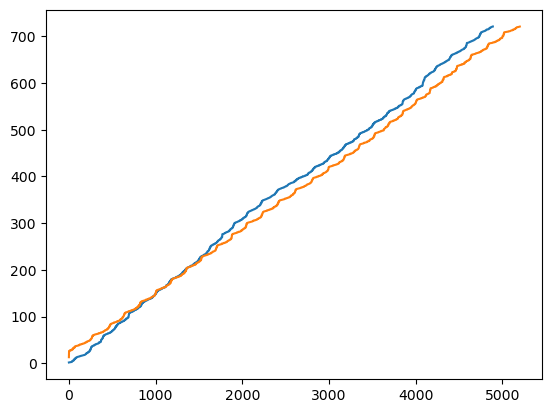

In [7]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot(timestamps_01)
ax.plot(timestamps_07)


In [8]:
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = []
    for day in range(days):
        pellets = [t for t in timestamps if (t>day*24) and (t<(day+1)*24)]
        n_pellets = len(pellets)
        pellets_per_day.append(n_pellets)

    return pellets_per_day

pellets_per_day_01 = get_pellets_per_day(timestamps_01, days=30)
pellets_per_day_07 = get_pellets_per_day(timestamps_07, days=30)

(0.0, 250.0)

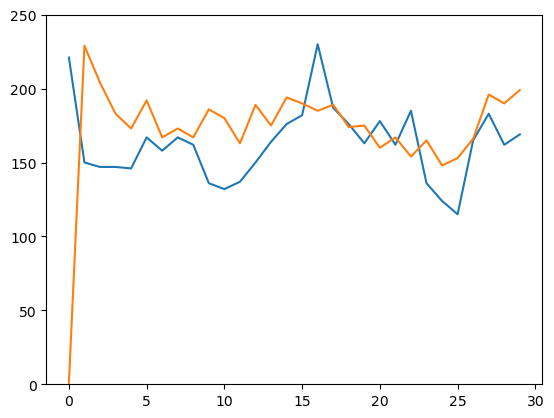

In [9]:
f, ax = plt.subplots()
ax.plot(pellets_per_day_01)
ax.plot(pellets_per_day_07)

ax.set_ylim([0,250])


[0.05055556 0.03388889 0.01138889 ... 0.00444444 0.005      0.00527778]
['red']
['green']


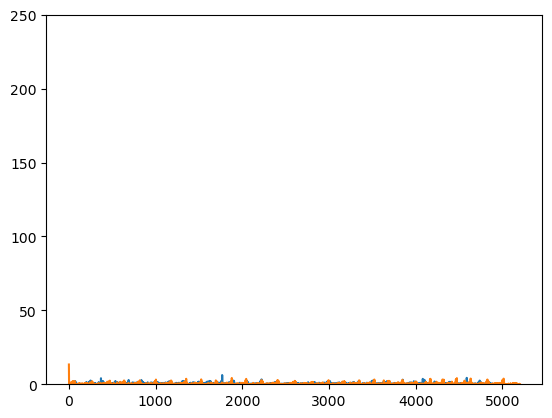

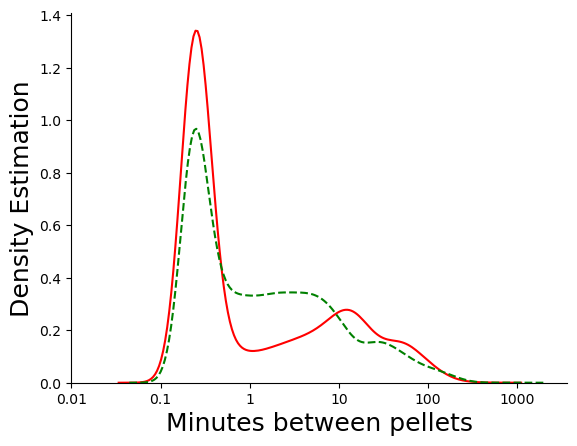

In [10]:
import seaborn as sns


def get_interpellet_intervals(pellettimes):
    IPIs = np.diff(pellettimes)
    return IPIs


interpellet_intervals_01 = get_interpellet_intervals(timestamps_01)
print (interpellet_intervals_01)
interpellet_intervals_07 = get_interpellet_intervals(timestamps_07)

f, ax = plt.subplots()
ax.plot(interpellet_intervals_01)
ax.plot(interpellet_intervals_07)

ax.set_ylim([0,250])


def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = (group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    
    
    
    



f, ax = plt.subplots()

interpellet_interval_plot([interpellet_intervals_01],
                           colors=[ "red"],
                           linestyle="-",
                           ax=ax)

interpellet_interval_plot([interpellet_intervals_07],
                           colors=["green"],
                           linestyle="--",
                           ax=ax)

[0.05055556 0.03388889 0.01138889 ... 0.00444444 0.005      0.00527778]


(0.0, 250.0)

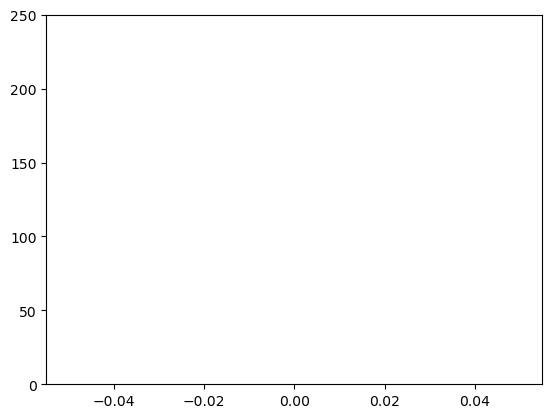

In [11]:

def get_intermealinterval (pellettimes):
    IPIs = np.diff(pellettimes)
    IMI= np.mean([x for x in IPIs if x > (1/60)])
    return IMI

intermeal_interval_01 = get_intermealinterval(timestamps_01)
print (interpellet_intervals_01)
intermeal_interval_07 = get_intermealinterval(timestamps_07)

f, ax = plt.subplots()
ax.plot(intermeal_interval_01)
ax.plot(intermeal_interval_07)

ax.set_ylim([0,250])


TypeError: 'float' object is not iterable

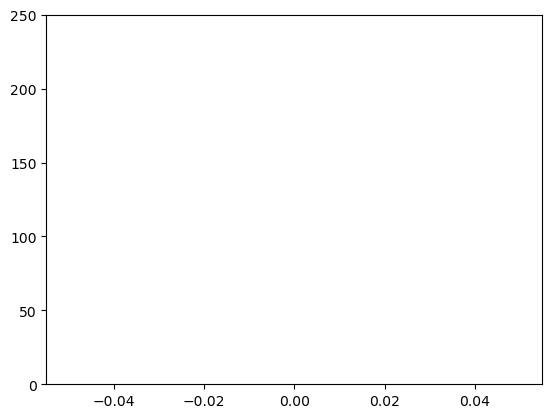

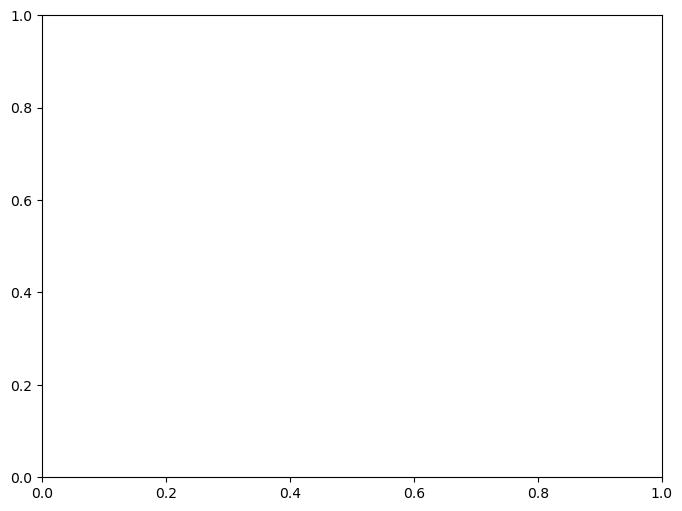

In [12]:

import trompy as tp
import matplotlib.pyplot as plt

def get_mealsize(pellettimes):
    """
    calculates meal size from times of pellets
    parameters 
    ----------
    pellettimes : list of floats
        timestamps of pellet deliveries

    returns
    --------
    mealsize : float 
        mean size of meal in pellets 
    """
    npellets = len(pellettimes)
    IPIs = np.diff(pellettimes)
    nmeals = len([idx for idx, val in enumerate(IPIs) if val > 1/60])
    mealsize = npellets/nmeals

    return mealsize
mealsize_01 = get_mealsize(timestamps_01)
print ()
mealsize_07 = get_mealsize(timestamps_07)

f, ax = plt.subplots()
ax.plot(mealsize_01)
ax.plot(mealsize_07)

ax.set_ylim([0,250])




mealsize_01 = get_mealsize(timestamps_01)
print ()
mealsize_07 = get_mealsize(timestamps_07)

f, ax = plt.subplots(figsize=(8,6))
_, _, barlist, _ = tp.barscatter([mealsize_01,mealsize_07], ax=ax, paired=True,linewidth =1, groupwidth = 0.70,show_legend= False) 
#_, _, barlist, _ = tp.barscatter([mealsize_01,mealsize_07], ax=ax, paired=True,linewidth =1, groupwidth = 0.70,show_legend= False,
#barfacecolor_option="individual",baredgecolor= ["white"]*8, barfacecolor=["red", "green"])
ax.set_ylabel("Pellets/meal",fontsize = 18)
ax.set_xlabel("")
plt.rcParams["hatch.linewidth"] = 3

In [13]:
mealsize_01

2.638619201725998